# Fitting function

## Needed sub functions:

In [1]:
def crit_temp(data_dir):
    '''Gives the transition/critical temperature from the measured specific
    heat in terms of k_B*T/J.
    
    Parameters
    ----------
    data_dir : datafile ~.npz
        contains the 'temperature' 'magnetic_field' 'c_v' 'chi' arrays
    
    Returns
    -------
    T_c: float
        the critical temperature    
    '''
    
    data = np.load(data_dir)
    T = data['temperature'].reshape(np.shape(data['temperature'])[0])
    c_v = data['c_v'][:,0]
    T_c = T[c_v==max(c_v)]
    
    return T_c

In [2]:
def load_data(data_dir, quantity):
    '''Loads all data from data_dir and assigns data of specific quantity to variables
    
    Parameters
    ----------
    data_dir : datafile ~.npz
        contains the 'temperature' 'magnetic_field' 'c_v' 'chi' 'magnetisation' arrays
    quantity : str
        quantity of interest
    
    Returns
    -------
    xdata : 1D array
        temperatures from data_dir
    ydata : 1D array
        quantity from data_dir
    y_err : 1D array
        standard deviation of ydata entries        
    '''
    
    data = np.load(data_dir)
    xdata = data['temperature'].reshape(np.shape(data['temperature'])[0])
    ydata = data[quantity][:,0]
    y_err = data[quantity][:,1]
    
    return xdata, ydata, y_err

In [3]:
def plot_function(data_dir, quantity, LOG):
    '''Gives plot of the function in loglog or normal scale. X-axis is
    translated with critical temperature T_c when the loglog plot is selected.
    
    Parameters
    ----------
    data_dir : datafile ~.npz
        contains the 'temperature' 'magnetic_field' 'c_v' 'chi' arrays
    quantity : Str
        string which specifies which physical quantity must be fitted
    LOG : boolean
        Turns loglog plot on or off
        
    Returns
    -------
    plot of data provided
    '''
    
    xdata, ydata, y_err = load_data(data_dir, quantity)
    
    T_c = crit_temp(data_dir)
    
    #if quantity == 'magnetisation':
    
    if LOG:
        plt.loglog(xdata[(xdata-T_c)>0]-T_c, ydata[(xdata-T_c)>0], 'bx')
        plt.loglog(abs(xdata[(xdata-T_c)<0]-T_c), ydata[(xdata-T_c)<0], 'rx')
        plt.grid()
    else:
        plt.plot(xdata[(xdata-T_c)>0]-T_c, ydata[(xdata-T_c)>0], 'bx')
        plt.plot(xdata[(xdata-T_c)<0]-T_c, ydata[(xdata-T_c)<0], 'rx')
        
    plt.tight_layout()
    plt.show()
        

## Actual fit function:

In [8]:
def fit_function(data_dir, quantity, fit_range, plotYN):
    '''Gives the best fit to quantity with non-linear least squares
    
    Parameters
    ----------
    data_dir : datafile ~.npz
        contains the 'temperature' 'magnetic_field' 'c_v' 'chi' arrays
    quantity : Str
        string which specifies which physical quantity must be fitted
    fit_range: sequence
        [LB, UB], the lower and upper boundary of the interval to be
        fitted w.r.t T_c
    plotYN : boolean
        turns plotting of fit and original function on or off
              
    Returns
    -------
    popt: array
        Optimal values for parameters so sum of the squared residuals is minimized
    fit_err: sequence
        Standard deviation of the optimal values for the parameters
    '''
    
    # Initialisation of plot design and parameters
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rc('font', size=18)
    plt.xlabel('$\mathrm{k_B T/J}$')
    
       
    # Loading data and general functions (and generate transition temperature (T_c))
    from scipy.optimize import curve_fit
    
    data = np.load(data_dir)
    xdata = data['temperature'].reshape(np.shape(data['temperature'])[0])
    ydata = data[quantity][:,0]
    y_err = data[quantity][:,1]
    
    T_c = crit_temp(data_dir)
    
    # Fitting
    ## Selecting data for fit
    indices = np.where(((xdata-T_c)>fit_range[0]) & ((xdata-T_c)<fit_range[1]))
    xdata_fit = xdata[indices] - T_c
    ydata_fit = ydata[indices]
    y_err_fit = y_err[indices]

    ## Select fitting model
    if quantity == 'magnetisation':
        from Model_equations_fitting import f_magnetisation as f
        plt.ylabel('m', fontsize=18)
    if quantity == 'c_v':
        from Model_equations_fitting import f_cv as f
        plt.ylabel('$\mathrm{C_v}$', fontsize=18)
    if quantity == 'chi':
        from Model_equations_fitting import f_chi as f
        plt.ylabel('$\mathrm{\chi}$', fontsize=18)
    
    ## Actual fitting
    popt, pcov = curve_fit(f, abs(xdata_fit), ydata_fit, sigma=y_err_fit)
    fit_err = np.sqrt(np.diag(pcov))

    # Generate fit plot data
    xdata_fit_plot = np.linspace(xdata_fit[0], xdata_fit[-1], 1000)
    ydata_fit_plot = f(abs(xdata_fit_plot), *popt)
        
    # Plotting original function and fit
    if plotYN:
                
        # Actual plotting
        plt.loglog(xdata[(xdata-T_c)>0]-T_c, ydata[(xdata-T_c)>0], 'bx', markersize=7)
        plt.loglog(abs(xdata[(xdata-T_c)<0]-T_c), ydata[(xdata-T_c)<0], 'rx', markersize=7)
        plt.loglog(abs(xdata_fit_plot),ydata_fit_plot, 'k-', alpha = 0.9, label = 'Fit +')
        #plt.loglog(abs(xdata_fit_plot),f(abs(xdata_fit_plot), *(popt+fit_err)), 'k-', alpha = 0.7)
        #plt.loglog(abs(xdata_fit_plot),f(abs(xdata_fit_plot), *(popt-fit_err)), 'k-', alpha = 0.7)
        plt.grid()
        #plt.tight_layout()
        #plt.show()
   
    return popt, fit_err, xdata_fit_plot, ydata_fit_plot

## Determine fit range visually:

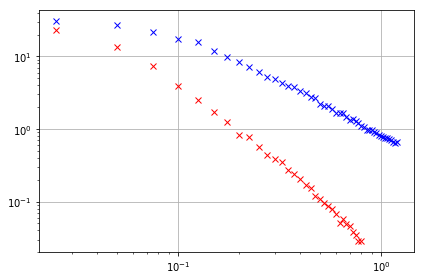

In [6]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib notebook

plot_function('./exported_data/saved_data_L40_SW_2000.npz', 'chi', True)

## Determine best fit & plot it:

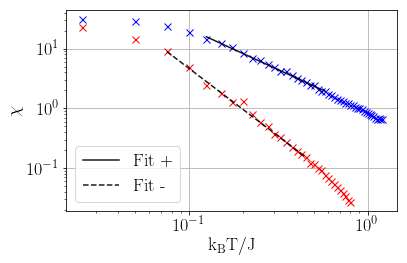

In [10]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib notebook

boundaries_neg = np.array([-0.46, -0.074])
popt_neg, fit_err_neg, xdata_fit_neg, ydata_fit_neg = fit_function('./exported_data/saved_data_L40_SW_5000.npz', 'chi', boundaries_neg, False)

boundaries_pos = np.array([0.124, 0.576])
popt_pos, fit_err_pos, xdata_fit_plot_pos, ydata_fit_plot_pos = fit_function('./exported_data/saved_data_L40_SW_5000.npz', 'chi', boundaries_pos, True)

plt.loglog(abs(xdata_fit_neg),ydata_fit_neg, 'k--', alpha = 0.9 ,label = 'Fit -')
plt.legend()
plt.tight_layout()
plt.show()

#plt.savefig('./exported_figs/L40_SW_5000' + '_chi_fitted.png')

In [11]:
print(popt_pos)
print(fit_err_pos)

[ 0.91317453 -1.37069533]
[ 0.02450026  0.02081675]


In [12]:
print(popt_neg)
print(fit_err_neg)

[ 0.02484569 -2.27266982]
[ 0.00086469  0.02759973]


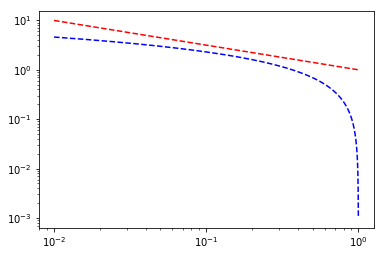

In [2]:
import numpy as np
import matplotlib.pyplot as plt

x_test = np.linspace(0.01, 1, 1000)
y_test1 = x_test**-0.5
y_test2 = abs(np.log(x_test))

plt.loglog(x_test,y_test1,'r--')
plt.loglog(x_test,y_test2,'b--')
plt.show()